# Logistic Regression with a Neural Network mindset

## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import skimage
%matplotlib inline

## 2 - Overview of the Problem set

In [2]:
#Loading the data (cat/non cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], This is a 'cat' picture'


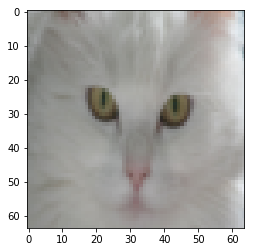

In [3]:
#Example of image
index = 50
example = train_set_x_orig[index]
plt.imshow(example)
print("y = " + str(train_set_y[:, index]) + ", This is a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture'")

In [4]:
#Find the values for: 
#- m_train (number of training examples)
#- m_test (number of test examples)
#- num_px (= height = width of a training image)

### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [5]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [6]:
#Let's standardize our dataset.
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

## 3 - General Architecture of the learning algorithm
It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why $Logistic Regression is actually a very simple Neural Network!$

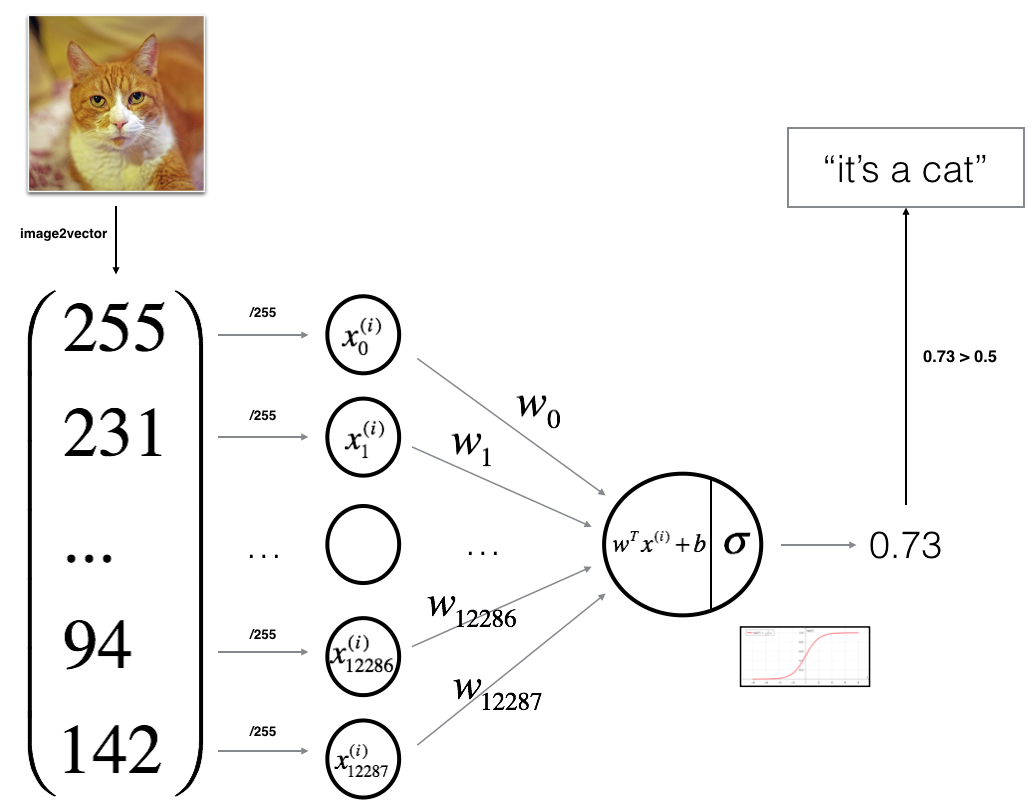

#### Mathematical expression of the algorithm:

For one example $x^{(i)}$: $$z^{(i)} = w^T x^{(i)} + b \tag{1}$$$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples: $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

$Key steps:$ In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## 4 - Building the parts of our algorithm

### 4.1 - Helper functions

In [9]:

# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

### 4.2 - Initializing parameters
$Exercise:$ Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [12]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# 4.3 - Forward and Backward propagation

$Exercise:$ Implement a function propagate() that computes the cost function and its gradient.

In [16]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b) #compute activation
    cost = (-1/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) #compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y, axis=1)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### d) Optimization
$Exercise:$ Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [20]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

$Exercise:$ The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There is two steps to computing predictions:

Calculate $\hat{Y} = A = \sigma(w^T X + b)$

Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [22]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    [print(x) for x in A]
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if(A[0,i]<=0.5):
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
        ### END CODE HERE ###
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## 5 - Merge all functions into a model
$Exercise:$ Implement the model function. Use the following notation:

- Y_prediction for your predictions on the test set
- Y_prediction_train for your predictions on the train set
- w, costs, grads for the outputs of optimize()

In [27]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent (≈ 1 line of code)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [58]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 3000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Cost after iteration 2000: 0.135608
Cost after iteration 2100: 0.130708
Cost after iteration 2200: 0.126137
Cost after iteration 2300: 0.121861
Cost after iteration 2400: 0.117855
Cost after iteration 2500: 0.114093
Cost after iteration 2600: 0.110554
Cost after iteration 2700: 0.107219
Cost

y = [0], You predicted that it is a 'cat' picture!


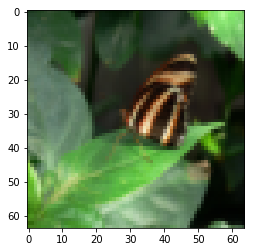

In [60]:
#Example of a picture that was wrongly classfied
index = 5
plt.imshow(test_set_x[:, index].reshape(num_px, num_px, 3))
print("y = " + str(test_set_y[:, index]) + ", You predicted that it is a '" + classes[int(d["Y_prediction_test"][:, index])].decode("utf-8") + "' picture!")

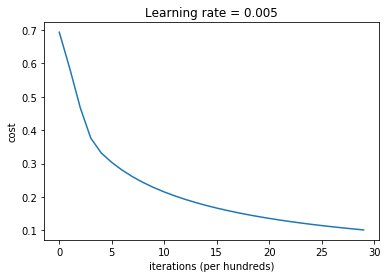

In [61]:
#Plot learning curve (with costs)
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

### Choose of learning rate

Learning rate is: 0.01
[1.47839654e-01 5.78008187e-02 9.42385025e-01 4.14849240e-05
 2.27209941e-02 7.29254668e-02 2.23704494e-02 9.49717864e-01
 5.41724296e-02 2.92729895e-02 6.82412300e-02 8.33370210e-01
 1.71420615e-01 9.66879883e-01 8.11537151e-01 2.44343483e-02
 7.87634098e-03 2.64027272e-02 5.60720049e-02 9.53130353e-01
 5.30865324e-03 3.11020745e-02 1.43606493e-01 1.92650473e-02
 9.30132798e-01 8.95291211e-01 2.72790550e-02 9.01480142e-01
 2.73987904e-02 8.09041583e-01 6.64266068e-02 5.00479730e-02
 1.29245158e-01 1.40274640e-01 6.48179131e-02 1.35261338e-02
 4.77693620e-03 2.65922710e-02 8.89771230e-01 2.64826222e-01
 1.22921585e-02 6.03229153e-01 8.81822076e-01 1.35079742e-02
 2.49595285e-02 6.88961126e-02 5.86046930e-02 8.68932415e-01
 5.14520331e-03 1.21099845e-02 8.23403970e-01 1.70985647e-01
 9.49977566e-02 3.04227660e-01 9.48091298e-01 8.09204729e-04
 9.66640038e-01 8.78319466e-01 3.17284880e-02 9.76165700e-01
 8.81584697e-01 8.48145722e-01 2.70795160e-02 2.28390397e-02
 

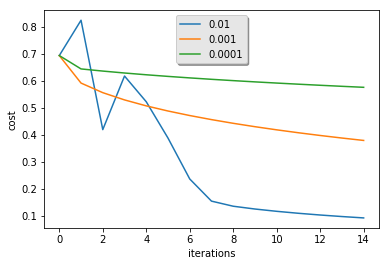

In [67]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("Learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print("\n-------------------------------------------------------------------------------\n")
    
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=models[str(i)]["learning_rate"])
    
plt.ylabel("cost")
plt.xlabel("iterations")

legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
    
plt.show()

### 7 - Test with your own image (optional/ungraded exercise)
Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:

1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

[0.05093869]
y = 0.0, your algorithm predicts a "non-cat" picture.


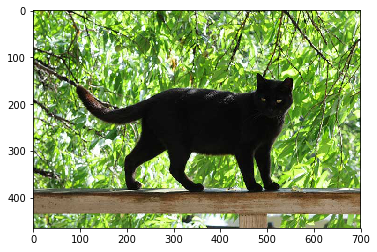

In [77]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image7.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")